## Deep Learning for NLP

##### Author: Alex Sherman | alsherman@deloitte.com


Agenda:


In [145]:
from configparser import ConfigParser, ExtendedInterpolation
import os
import numpy as np
import pandas as pd
from numpy import array
from numpy import asarray
from numpy import zeros
from IPython.core.display import display, HTML
from IPython.display import Image
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, \
    Embedding, Input, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.initializers import Constant
from keras.utils import to_categorical

### Problem Definition

In [16]:
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

REPORTER_DATA_PATH = config['DATA']['REPORTER_DATA_PATH']

In [17]:
df = pd.read_csv(
    REPORTER_DATA_PATH,
    encoding='latin-1'  # common encoding to handle messy data
)
df.head()

,APPLICATION_ID,ACTIVITY,ADMINISTERING_IC,APPLICATION_TYPE,ARRA_FUNDED,AWARD_NOTICE_DATE,BUDGET_START,BUDGET_END,CFDA_CODE,CORE_PROJECT_NUM,...,SERIAL_NUMBER,STUDY_SECTION,STUDY_SECTION_NAME,SUBPROJECT_ID,SUFFIX,SUPPORT_YEAR,DIRECT_COST_AMT,INDIRECT_COST_AMT,TOTAL_COST,TOTAL_COST_SUB_PROJECT
0,9260950,R01,MH,5.0,N,02/28/2017,03/01/2017,02/28/2018,242.0,R01MH100027,...,100027,ZHD1,Special Emphasis Panel,NaN,NaN,10.0,2364258.0,395326.0,2759584.0,NaN
1,9277747,U54,CA,2.0,N,05/12/2017,05/12/2017,04/30/2018,397.0,U54CA163004,...,163004,ZCA1,Special Emphasis Panel,NaN,NaN,6.0,978861.0,331222.0,1310083.0,NaN
2,9466899,SB1,ES,2.0,N,09/12/2017,09/15/2017,08/31/2018,113.0,SB1ES022880,...,022880,ZRG1,Special Emphasis Panel,NaN,NaN,4.0,94518.0,93953.0,199968.0,NaN
3,9255779,R43,GM,1.0,N,03/14/2017,04/01/2017,03/31/2019,859.0,R43GM122226,...,122226,ZRG1,Special Emphasis Panel,NaN,NaN,1.0,NaN,NaN,223866.0,NaN
4,9556855,ZIC,CA,1.0,N,NaN,NaN,NaN,NaN,ZICBC011574,...,011574,NaN,NaN,NaN,NaN,4.0,NaN,NaN,466646.0,NaN


In [18]:
# filter to relevant columns
df = df[['ADMINISTERING_IC', 'FY',  'IC_NAME', 'PROJECT_TITLE']]
df.head()

,ADMINISTERING_IC,FY,IC_NAME,PROJECT_TITLE
0,MH,2017,NATIONAL INSTITUTE OF MENTAL HEALTH,"Autism Genetics, Phase II: Increasing Represen..."
1,CA,2017,NATIONAL CANCER INSTITUTE,The Role of the Microenvironment in Barrett's ...
2,ES,2017,NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCI...,Low-Cost Catalytic Biomass Cookstove for Impro...
3,GM,2017,NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES,Surgical Wound Closure Matrices for the Preven...
4,CA,2017,NATIONAL CANCER INSTITUTE,LRBGE Optical Microscopy Core


In [19]:
# observe IC representation in dataset
df['IC_NAME'].value_counts()

NATIONAL CANCER INSTITUTE                                                          11406
NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES                               7744
NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES                                      7587
NATIONAL HEART, LUNG, AND BLOOD INSTITUTE                                           6456
NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES                    5051
NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS AND STROKE                             4591
NATIONAL INSTITUTE ON AGING                                                         3928
NATIONAL INSTITUTE OF MENTAL HEALTH                                                 3515
EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF CHILD HEALTH & HUMAN DEVELOPMENT       3375
NATIONAL INSTITUTE ON DRUG ABUSE                                                    2569
NATIONAL EYE INSTITUTE                                                              1809
NATIONAL INSTITUTE OF

In [20]:
# convert IC counts to a dataframe
top_ic = df['IC_NAME'].value_counts().reset_index()
# filter to top ICs
top_ic_names = top_ic[top_ic.IC_NAME > 1500]['index']
# view results
top_ic_names

0                             NATIONAL CANCER INSTITUTE
1     NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS D...
2        NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES
3             NATIONAL HEART, LUNG, AND BLOOD INSTITUTE
4     NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE A...
5     NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS A...
6                           NATIONAL INSTITUTE ON AGING
7                   NATIONAL INSTITUTE OF MENTAL HEALTH
8     EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF C...
9                      NATIONAL INSTITUTE ON DRUG ABUSE
10                               NATIONAL EYE INSTITUTE
11    NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCI...
12    NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKE...
Name: index, dtype: object

In [21]:
df = df[df['IC_NAME'].isin(top_ic_names)]
df.shape

(61363, 4)

In [22]:
# factorizer - convert categories to numbers
df['IC_NAME'].factorize()

(array([ 0,  1,  2, ...,  1, 11,  1], dtype=int64),
 Index(['NATIONAL INSTITUTE OF MENTAL HEALTH', 'NATIONAL CANCER INSTITUTE',
        'NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCIENCES',
        'NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES',
        'NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS AND STROKE',
        'NATIONAL INSTITUTE ON AGING',
        'NATIONAL HEART, LUNG, AND BLOOD INSTITUTE',
        'NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES',
        'EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF CHILD HEALTH & HUMAN DEVELOPMENT',
        'NATIONAL EYE INSTITUTE', 'NATIONAL INSTITUTE ON DRUG ABUSE',
        'NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES',
        'NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES'],
       dtype='object'))

In [23]:
# set the labels
df['IC_NUM'] = df['ADMINISTERING_IC'].factorize()[0]
df.head()

,ADMINISTERING_IC,FY,IC_NAME,PROJECT_TITLE,IC_NUM
0,MH,2017,NATIONAL INSTITUTE OF MENTAL HEALTH,"Autism Genetics, Phase II: Increasing Represen...",0
1,CA,2017,NATIONAL CANCER INSTITUTE,The Role of the Microenvironment in Barrett's ...,1
2,ES,2017,NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCI...,Low-Cost Catalytic Biomass Cookstove for Impro...,2
3,GM,2017,NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES,Surgical Wound Closure Matrices for the Preven...,3
4,CA,2017,NATIONAL CANCER INSTITUTE,LRBGE Optical Microscopy Core,1


In [24]:
# create a map of IC num to name for later reference
ic_name_map = {num:name for num, name in df[['IC_NUM','IC_NAME']].drop_duplicates().values}
ic_name_map

{0: 'NATIONAL INSTITUTE OF MENTAL HEALTH',
 1: 'NATIONAL CANCER INSTITUTE',
 2: 'NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCIENCES',
 3: 'NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES',
 4: 'NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS AND STROKE',
 5: 'NATIONAL INSTITUTE ON AGING',
 6: 'NATIONAL HEART, LUNG, AND BLOOD INSTITUTE',
 7: 'NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES',
 8: 'EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF CHILD HEALTH & HUMAN DEVELOPMENT',
 9: 'NATIONAL EYE INSTITUTE',
 10: 'NATIONAL INSTITUTE ON DRUG ABUSE',
 11: 'NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES',
 12: 'NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES'}

### Preprocess data and create Train/Test splits

In [25]:
# separate the features and response
X = df['PROJECT_TITLE']
y = df['IC_NUM']

In [26]:
# use gensim to preprocess text 

for title in X[0:5]:
    clean_title_tokens = simple_preprocess(title)
    clean_title = ' '.join(clean_title_tokens)
    
    print(title)
    print(clean_title_tokens)
    print(clean_title)
    print()

Autism Genetics, Phase II: Increasing Representation of Human Diversity
['autism', 'genetics', 'phase', 'ii', 'increasing', 'representation', 'of', 'human', 'diversity']
autism genetics phase ii increasing representation of human diversity

The Role of the Microenvironment in Barrett's Esophagus
['the', 'role', 'of', 'the', 'in', 'barrett', 'esophagus']
the role of the in barrett esophagus

Low-Cost Catalytic Biomass Cookstove for Improved Indoor Air Quality
['low', 'cost', 'catalytic', 'biomass', 'cookstove', 'for', 'improved', 'indoor', 'air', 'quality']
low cost catalytic biomass cookstove for improved indoor air quality

Surgical Wound Closure Matrices for the Prevention of Superficial Incisional SSI
['surgical', 'wound', 'closure', 'matrices', 'for', 'the', 'prevention', 'of', 'superficial', 'incisional', 'ssi']
surgical wound closure matrices for the prevention of superficial incisional ssi

LRBGE Optical Microscopy Core
['lrbge', 'optical', 'microscopy', 'core']
lrbge optical mi

In [27]:
# use gensim to preprocess text 

def preprocess_text(text):
    """ use gensim simple_preprocess to tokenize text. Join results back into a clean text string
    
    :param text: string, text to preprocess
    """
    
    clean_tokens = simple_preprocess(text)
    clean_text = ' '.join(clean_tokens)
    
    return clean_text


X = X.apply(lambda x: preprocess_text(x))

In [29]:
# Create train test splits

from sklearn.model_selection import train_test_split

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42)

y_train.value_counts(normalize=True)

1     0.185889
11    0.126201
3     0.123637
6     0.105211
7     0.082308
4     0.074812
5     0.064013
0     0.057277
8     0.054995
10    0.041871
9     0.029486
2     0.028617
12    0.025683
Name: IC_NUM, dtype: float64

##### Explore Data

In [33]:
# view the distribution of words in a project title
X_train.apply(len).describe()

count    46022.000000
mean        60.746860
std         25.154798
min          0.000000
25%         44.000000
50%         60.000000
75%         76.000000
max        199.000000
Name: PROJECT_TITLE, dtype: float64

# Keras

In [42]:
sqlalchemy_url = 'https://keras.io/'
iframe = '<iframe src={} width=1100 height=600></iframe>'.format(sqlalchemy_url)
HTML(iframe)

C:\Users\alsherman\AppData\Local\Continuum\miniconda3\envs\guild\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


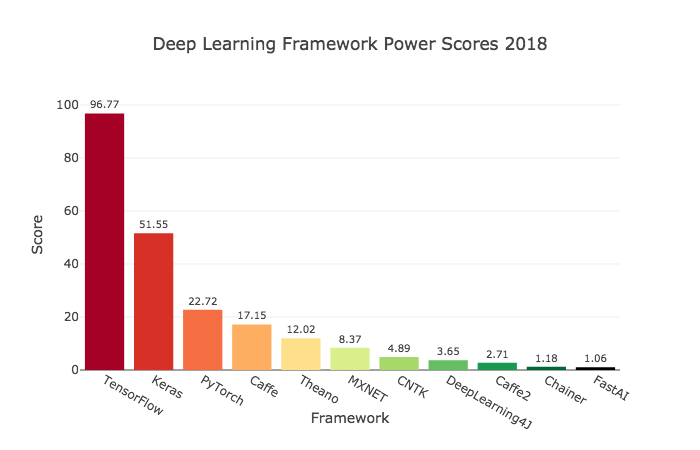

In [47]:
# Keras rankings
Image("../../raw_data/images/dl_frameworks_power_scores.png", width=700, height=700)

# Document Classification with Deep Learning Approach

#### 1. convert all text samples in the dataset into sequences of word indices. 
- A "word index" would simply be an integer ID for the word. 
- We will only consider the top N most commonly occuring words in the dataset, and we will truncate the sequences to a defined maximum length of words.

#### 2. prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.


#### 3. load this embedding matrix into a Keras Embedding layer, set to be frozen 
- its weights, the embedding vectors, will not be updated during training.


#### 4. build a deep learning model (e.g. CNN, RNN), ending in a softmax output.



SOURCE: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

# 1. convert all text samples in the dataset into sequences of word indices. 

In [48]:
# get a count of the number of possible categories to predict
num_classes = len(set(y_train))
num_classes

13

In [49]:
# convert the training and testing dataset
y_train_array = to_categorical(y_train, num_classes)
y_test_array = to_categorical(y_test, num_classes)

# each label is one-hot encoded into a vector of size num_classes
y_train_array

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### Keras Tokenizer

In [50]:
# prepare tokenizer
MAX_NUM_WORDS = 25000

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

In [51]:
print(dir(tokenizer))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'char_level', 'document_count', 'filters', 'fit_on_sequences', 'fit_on_texts', 'get_config', 'index_docs', 'index_word', 'lower', 'num_words', 'oov_token', 'sequences_to_matrix', 'sequences_to_texts', 'sequences_to_texts_generator', 'split', 'texts_to_matrix', 'texts_to_sequences', 'texts_to_sequences_generator', 'to_json', 'word_counts', 'word_docs', 'word_index']


In [52]:
# Signature: t.fit_on_texts(texts)
tokenizer.fit_on_texts(X_train)

##### Example what the tokenizer has learned from the text

In [53]:
tokenizer.document_count

46022

In [63]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

20439

In [58]:
# get word counts that the tokenizer learned
list(tokenizer.word_counts.items())[0:10]

[('determining', 79),
 ('the', 8779),
 ('role', 2315),
 ('of', 22665),
 ('dnmt', 9),
 ('interacting', 21),
 ('rnas', 83),
 ('in', 15958),
 ('myeloid', 91),
 ('disorders', 353)]

In [59]:
# view the most common words
sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[0:10]

[('of', 22665),
 ('and', 17661),
 ('in', 15958),
 ('the', 8779),
 ('for', 7141),
 ('to', 4392),
 ('core', 3996),
 ('cancer', 3021),
 ('cell', 2685),
 ('research', 2425)]

In [60]:
# get counts of in how many documents each token exists
list(tokenizer.word_docs.items())[0:10]

[('role', 2315),
 ('of', 20429),
 ('interacting', 21),
 ('disorders', 353),
 ('in', 15331),
 ('determining', 79),
 ('rnas', 83),
 ('the', 7864),
 ('dnmt', 9),
 ('myeloid', 91)]

In [61]:
# get a word to index mapping
list(tokenizer.word_index.items())[0:10]

[('of', 1),
 ('and', 2),
 ('in', 3),
 ('the', 4),
 ('for', 5),
 ('to', 6),
 ('core', 7),
 ('cancer', 8),
 ('cell', 9),
 ('research', 10)]

In [62]:
# get a index to word mapping
list(tokenizer.index_word.items())[0:10]

[(1, 'of'),
 (2, 'and'),
 (3, 'in'),
 (4, 'the'),
 (5, 'for'),
 (6, 'to'),
 (7, 'core'),
 (8, 'cancer'),
 (9, 'cell'),
 (10, 'research')]

##### convert the sentences to a sequence of token ids

In [64]:
encoded_docs = tokenizer.texts_to_sequences(X_train)
print(X_train[0:5])
encoded_docs[0:5]

10516    determining the role of dnmt interacting rnas ...
65466                                      morphology core
57760    cognitive and neural moderators of longitudina...
50413    exploiting mutant idh induced homologous recom...
53219    analysis of intracellular host defenses in sal...
Name: PROJECT_TITLE, dtype: object


[[688, 4, 12, 1, 3690, 2063, 660, 3, 599, 134],
 [1367, 7],
 [98, 2, 67, 3691, 1, 311, 761, 3, 1935, 611],
 [1231, 554, 1989, 48, 2409, 820, 717, 3, 8],
 [34, 1, 798, 122, 2919, 3, 1173, 97]]

##### pad the sequences to make the matrix size consistent

In [65]:
# pad documents to a max length of 10 words

MAX_SEQ_LENGTH = 10
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQ_LENGTH, padding='post')
print(padded_docs[0:5])

[[ 688    4   12    1 3690 2063  660    3  599  134]
 [1367    7    0    0    0    0    0    0    0    0]
 [  98    2   67 3691    1  311  761    3 1935  611]
 [1231  554 1989   48 2409  820  717    3    8    0]
 [  34    1  798  122 2919    3 1173   97    0    0]]


In [66]:
# encode both train and test data (only learn from the training data)

def encode_text(text):
    """ convert an array of text into a series of padded token interger-ids 
    
    :param text: series, text to tokenize and pad with 0's
    """
    
    encoded_docs = tokenizer.texts_to_sequences(text)
    padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQ_LENGTH, padding='post')    
    
    return padded_docs


X_train_sequence = encode_text(X_train)
X_test_sequence = encode_text(X_test)

# 2. prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.

### Download pre-trained embeddings

##### GLOVE
- GLoVE - Global Vectors for Word Representation: https://nlp.stanford.edu/projects/glove/
- Publication: https://nlp.stanford.edu/pubs/glove.pdf

In [67]:
%ls

 Volume in drive C is OSDisk
 Volume Serial Number is 1E90-A1EF

 Directory of C:\Users\alsherman\Desktop\NLP\nlp_practicum_cohort3\lessons\lesson_6_deep_learning_for_nlp

05/27/2019  10:41 AM    <DIR>          .
05/27/2019  10:41 AM    <DIR>          ..
05/24/2019  09:35 PM    <DIR>          .ipynb_checkpoints
05/26/2019  05:12 PM     1,341,997,858 biomedicalWordVectors.tar.gz
05/27/2019  10:41 AM           312,270 Deep Learning for NLP.ipynb
08/04/2014  01:14 PM       347,116,733 glove.6B.100d.txt
08/04/2014  01:14 PM       693,432,828 glove.6B.200d.txt
08/27/2014  12:19 PM     1,037,962,819 glove.6B.300d.txt
08/04/2014  01:15 PM       171,350,079 glove.6B.50d.txt
05/14/2019  12:19 AM       862,182,613 glove.6B.zip
10/24/2015  10:35 AM     5,646,236,541 glove.840B.300d.txt
05/26/2019  02:21 PM     2,176,768,927 glove.840B.300d.zip
05/26/2019  08:46 PM     3,985,791,418 pubmed2018_w2v_400D.tar.gz
05/26/2019  08:50 PM     4,416,560,851 wikipedia-pubmed-and-PMC-w2v.bin
05/26/2019  05:17

In [68]:
# Glove Word Embeddings
GLOVE_DIR = os.path.join('TODO', 'glove.6B.50d.txt') 
GLOVE_DIR = 'glove.6B.50d.txt' 

In [69]:
with open(GLOVE_DIR) as f:
    for line in f:
        print(line, '\n')
        break

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
 



In [70]:
# iterate and extract the embeddings

with open(GLOVE_DIR, 'rb') as f:

    for line in f:
        # separate the word from the embedding
        values = line.split()
        word = values[0].decode('utf-8')  # decode bytes to unicode
        embedding = np.asarray(values[1:], dtype='float32')

        # print the results
        print(f'WORD: {word}\n')
        print(f'EMBEDDING: {embedding}')

        break

WORD: the

EMBEDDING: [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


In [71]:
# Store all embeddings {'token': n-dimensional embedding_series}

embeddings_index = {}

with open(GLOVE_DIR, 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0].decode('utf-8')
        embedding = np.asarray(values[1:], dtype='float32')

        # store the embeddings in a dict
        embeddings_index[word] = embedding
        
        print(embeddings_index)
        break

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)}


In [72]:
%%time

# Store all embeddings {'token': n-dimensional embedding_series}
embeddings_index = {}

with open(GLOVE_DIR, 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0].decode('utf-8')
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.
Wall time: 14.9 s


##### View the stored embeddings

In [73]:
embeddings_index['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

##### Test out other words to see if a pre-trained embedding exists

In [74]:
word = "word" # test out new words in the quotes (capitalization sensitive)

embeddings_index[word]

array([-0.1643   ,  0.15722  , -0.55021  , -0.3303   ,  0.66463  ,
       -0.1152   , -0.2261   , -0.23674  , -0.86119  ,  0.24319  ,
        0.074499 ,  0.61081  ,  0.73683  , -0.35224  ,  0.61346  ,
        0.0050975, -0.62538  , -0.0050458,  0.18392  , -0.12214  ,
       -0.65973  , -0.30673  ,  0.35038  ,  0.75805  ,  1.0183   ,
       -1.7424   , -1.4277   ,  0.38032  ,  0.37713  , -0.74941  ,
        2.9401   , -0.8097   , -0.66901  ,  0.23123  , -0.073194 ,
       -0.13624  ,  0.24424  , -1.0129   , -0.24919  , -0.06893  ,
        0.70231  , -0.022177 , -0.64684  ,  0.59599  ,  0.027092 ,
        0.11203  ,  0.61214  ,  0.74339  ,  0.23572  , -0.1369   ],
      dtype=float32)

##### Determine if the words learned from the tokenizer have existing embeddings

In [75]:
list(tokenizer.index_word.items())[0:10]

[(1, 'of'),
 (2, 'and'),
 (3, 'in'),
 (4, 'the'),
 (5, 'for'),
 (6, 'to'),
 (7, 'core'),
 (8, 'cancer'),
 (9, 'cell'),
 (10, 'research')]

In [76]:
# iterate through all the words in the sentence
for ind, word in list(tokenizer.index_word.items())[0:10]:

    # get the embedding for the word
    embedding_vector = embeddings_index.get(word, 'no embedding')

    # view the word and embedding
    print(word)
    print(embedding_vector, '\n')

of
[ 0.70853    0.57088   -0.4716     0.18048    0.54449    0.72603
  0.18157   -0.52393    0.10381   -0.17566    0.078852  -0.36216
 -0.11829   -0.83336    0.11917   -0.16605    0.061555  -0.012719
 -0.56623    0.013616   0.22851   -0.14396   -0.067549  -0.38157
 -0.23698   -1.7037    -0.86692   -0.26704   -0.2589     0.1767
  3.8676    -0.1613    -0.13273   -0.68881    0.18444    0.0052464
 -0.33874   -0.078956   0.24185    0.36576   -0.34727    0.28483
  0.075693  -0.062178  -0.38988    0.22902   -0.21617   -0.22562
 -0.093918  -0.80375  ] 

and
[ 0.26818   0.14346  -0.27877   0.016257  0.11384   0.69923  -0.51332
 -0.47368  -0.33075  -0.13834   0.2702    0.30938  -0.45012  -0.4127
 -0.09932   0.038085  0.029749  0.10076  -0.25058  -0.51818   0.34558
  0.44922   0.48791  -0.080866 -0.10121  -1.3777   -0.10866  -0.23201
  0.012839 -0.46508   3.8463    0.31362   0.13643  -0.52244   0.3302
  0.33707  -0.35601   0.32431   0.12041   0.3512   -0.069043  0.36885
  0.25168  -0.24517   0.253

In [77]:
embeddings_count = 0
oov = []

for ind, word in list(tokenizer.index_word.items()):
    # get the embedding for the word
    embedding_exists = embeddings_index.get(word, False)
    
    # count the embeddings that were pre-trained; keep track of out of vocabulary (oov) words
    if embedding_exists is not False:
        embeddings_count += 1
    else:
        oov.append(word)

# calculate the percentage of words that existed in the pre-trained embeddings
print(f'{embeddings_count / len(tokenizer.index_word): 2.2f}% words existed in pre-trained embeddings \n')
print(f'OUT OF VOCABULARY WORDS: \n{oov[0:20]}')

 0.72% words existed in pre-trained embeddings 

OUT OF VOCABULARY WORDS: 
['phenotyping', 'predoctoral', 'crispr', 'cardiometabolic', 'biospecimen', 'synuclein', 'optogenetic', 'metabolomic', 'biorepository', 'crcns', 'epigenomic', 'ncorp', 'mtorc', 'inflammasome', 'transcriptomic', 'proteostasis', 'epigenomics', 'hhsn', 'abeta', 'neuroaids']


In [78]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50))

for word, i in tokenizer.word_index.items():    
    embedding_vector = embeddings_index.get(word)
    
    # add each word in the embedding_matrix in the slot for the tokenizer's word id
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [79]:
# view the embedding look up table
print(embedding_matrix[0:5])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.08530009e-01  5.70879996e-01 -4.71599996e-01  1.80480003e-01
   5.44489980e-01  7.26029992e-01  1.81569993e-01 -5.23930013e-01
   1.03809997e-01 -1.75659999e-01  7.8851

##### View an example of looking up a word by the tokenizer id in the embedding matrix

In [80]:
embeddings_index['good']

array([-3.5586e-01,  5.2130e-01, -6.1070e-01, -3.0131e-01,  9.4862e-01,
       -3.1539e-01, -5.9831e-01,  1.2188e-01, -3.1943e-02,  5.5695e-01,
       -1.0621e-01,  6.3399e-01, -4.7340e-01, -7.5895e-02,  3.8247e-01,
        8.1569e-02,  8.2214e-01,  2.2220e-01, -8.3764e-03, -7.6620e-01,
       -5.6253e-01,  6.1759e-01,  2.0292e-01, -4.8598e-02,  8.7815e-01,
       -1.6549e+00, -7.7418e-01,  1.5435e-01,  9.4823e-01, -3.9520e-01,
        3.7302e+00,  8.2855e-01, -1.4104e-01,  1.6395e-02,  2.1115e-01,
       -3.6085e-02, -1.5587e-01,  8.6583e-01,  2.6309e-01, -7.1015e-01,
       -3.6770e-02,  1.8282e-03, -1.7704e-01,  2.7032e-01,  1.1026e-01,
        1.4133e-01, -5.7322e-02,  2.7207e-01,  3.1305e-01,  9.2771e-01],
      dtype=float32)

In [81]:
token_id = tokenizer.texts_to_sequences(['good'])
token_id

[[8769]]

In [82]:
print(embedding_matrix[token_id[0]])

[[-3.55859995e-01  5.21300018e-01 -6.10700011e-01 -3.01310003e-01
   9.48620021e-01 -3.15389991e-01 -5.98309994e-01  1.21880002e-01
  -3.19430009e-02  5.56949973e-01 -1.06210001e-01  6.33989990e-01
  -4.73399997e-01 -7.58949965e-02  3.82470012e-01  8.15690011e-02
   8.22139978e-01  2.22200006e-01 -8.37639999e-03 -7.66200006e-01
  -5.62529981e-01  6.17590010e-01  2.02920005e-01 -4.85979989e-02
   8.78149986e-01 -1.65489995e+00 -7.74179995e-01  1.54349998e-01
   9.48230028e-01 -3.95200014e-01  3.73020005e+00  8.28549981e-01
  -1.41039997e-01  1.63950007e-02  2.11150005e-01 -3.60849984e-02
  -1.55870005e-01  8.65830004e-01  2.63090014e-01 -7.10150003e-01
  -3.67700011e-02  1.82819995e-03 -1.77039996e-01  2.70319998e-01
   1.10260002e-01  1.41330004e-01 -5.73219992e-02  2.72069991e-01
   3.13050002e-01  9.27709997e-01]]


##### Create embeddings for an entire sentence

In [97]:
example_sentence = X_train[0]
example_sentence

'autism genetics phase ii increasing representation of human diversity'

In [98]:
sentence_ids = tokenizer.texts_to_sequences([example_sentence])
sentence_ids

[[316, 167, 220, 367, 1384, 2885, 1, 30, 390]]

In [99]:
# structure the embeddings of each word in a sentence
sentence_embedding = pd.DataFrame(
    [embedding_matrix[word_id] for word_id in sentence_ids][0],  # store the embedding of each word in a list
    index=example_sentence.split()  # use the words (from the original sentence) as the row index
)

sentence_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
autism,1.336700,0.483980,-0.070310,-0.47615,-0.728760,2.398800,-0.166770,-1.468300,1.10760,0.682530,...,-0.43317,-0.231480,-0.603400,1.531700,0.56115,0.44502,0.38239,0.909420,0.303240,0.495220
genetics,0.381100,-0.027596,-1.051600,0.56067,0.323210,1.205100,-0.251660,-1.349700,1.11560,-0.103750,...,-0.39468,-0.810370,0.169400,1.034500,0.72777,0.69540,1.48470,0.617980,-0.121490,0.383430
phase,1.061600,0.274430,-0.252800,0.43043,-0.531820,0.136820,0.864920,0.091777,0.21752,0.412720,...,-0.61164,-0.863380,-0.384230,-0.168480,-0.32631,-0.14538,1.37240,0.409720,-0.237720,0.364040
ii,1.098800,1.024800,-0.021138,-0.49500,-0.038914,-0.008532,0.558440,-0.095818,-0.87519,-0.631620,...,0.29140,-0.107670,0.059000,-0.946740,0.14383,0.77221,-0.35722,-1.231800,-1.220800,0.098249
increasing,0.064295,0.369170,0.531780,-0.77435,-0.217590,0.360780,0.504830,-0.563590,0.93639,0.400430,...,-0.57452,0.153030,0.204620,-0.040293,0.12739,-0.52481,0.11304,0.495610,-0.082298,-0.044183
representation,-0.207190,0.113470,-0.492140,0.39233,1.408100,0.826890,1.133300,-0.610640,-0.20473,0.048441,...,0.29945,-0.199480,-0.223360,0.556970,-1.72730,-0.11378,-0.14065,0.529610,0.806610,-0.275590
of,0.708530,0.570880,-0.471600,0.18048,0.544490,0.726030,0.181570,-0.523930,0.10381,-0.175660,...,-0.34727,0.284830,0.075693,-0.062178,-0.38988,0.22902,-0.21617,-0.225620,-0.093918,-0.803750
human,0.618540,0.119150,-0.467860,0.31368,1.033400,0.959640,0.878030,-1.034600,1.63220,0.293470,...,-0.55007,-0.079205,0.633890,0.514460,0.70124,0.27638,-0.53445,0.064808,-0.219740,-0.520480
diversity,-0.274610,0.879090,-1.096200,0.51260,1.059600,0.159130,0.017131,-1.422700,1.17790,0.294100,...,-0.54499,-0.328190,-0.143880,0.516840,-0.29009,0.39579,0.30882,0.706400,-0.534720,0.454940


### average the embeddings as a simple example of how to combine embeddings

[A Simple but Tough-To-Beat Baseline for Sentence Embeddings](https://openreview.net/pdf?id=SyK00v5xx):
Sanjeev Arora, Yingyu Liang, Tengyu Ma 



In [86]:
pd.DataFrame(sentence_embedding.mean()).T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.531974,0.423042,-0.376874,0.071632,0.316857,0.751629,0.41331,-0.775278,0.579011,0.135629,...,-0.318388,-0.242435,-0.023585,0.326309,-0.052467,0.225539,0.268096,0.252903,-0.155648,0.016875


In [120]:
def create_embeddings_baseline(data_sequences):
    """ create a baseline by averaging all the embeddings in a sentence. This provides a single
    array to describe the document, which allows the use of standard statistical models (e.g. logistic regression)
    
    :param data_sequences: 2d-list, list of lists contains id mappings for words in a sentence 
    """
    
    # store all averaged embeddings for all sentences
    averaged_sentence_embeddings = []
    
    # iterate through all sentences
    for sentence_sequence in data_sequences:
        
        # convert id sequence into embeddings for one sentence
        embeddings = [] # store embedding of one sentence
        for word_id in sentence_sequence:
            embedding = embedding_matrix[word_id]
            embeddings.append(embedding)

        # average the embeddings of one sentence
        avg_embeddings = pd.DataFrame(embeddings).mean().values
        averaged_sentence_embeddings.append(avg_embeddings)

    # store all averaged embeddings in a dataframe
    avg_emb_df = pd.DataFrame(averaged_sentence_embeddings)
    
    return avg_emb_df

In [121]:
X_train_avg_emb_df = create_embeddings_baseline(X_train_sequence)
X_test_avg_emb_df = create_embeddings_baseline(X_test_sequence)

X_train_avg_emb_df.head()

In [125]:
# train model
logreg = LogisticRegression(solver='lbfgs', max_iter=300, multi_class='auto')
logreg.fit(X_train_avg_emb_df, y_train)

# store predictions
y_pred = logreg.predict(X_test_avg_emb_df)
y_pred_proba = logreg.predict_proba(X_test_avg_emb_df)

# evaluate model
print(f'accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'log loss (cross-entropy): {metrics.log_loss(y_test, y_pred_proba)}')

accuracy: 0.43224040153836124
log loss (cross-entropy): 1.8014815321104016


C:\Users\alsherman\AppData\Local\Continuum\miniconda3\envs\guild\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# 3. load this embedding matrix into a Keras Embedding layer, set to be frozen 

In [126]:
# define model
model = Sequential()

##### Specifying the input shape

The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. For an embedding layer, the input length is the number of tokens passed as input. The embedding itself has a size of (vocab_size * embedding_dimension_size).

### Embedding Layer

In [127]:
# reminder - number of words learned from the vocabulary
vocab_size

20439

In [128]:
# create an embedding layer from the pre-trained embeddings
e = Embedding(
  input_dim=vocab_size,                             # input (valid vocabulary) size
  output_dim=50,                                    # output size (dimensionality of pre-trained embeddings)
  input_length=MAX_SEQ_LENGTH,                      # Length of input sequences, when it is constant (max words allowed in a sentence)
  embeddings_initializer=Constant(embedding_matrix),# add pre-trained embeddings
  trainable=False                                   # prevent updates to the prtrained embeddings during model training
)

In [129]:
# add embedding to the model
model.add(e)

Keras offers an Embedding layer that can be used for neural networks on text data. It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

**The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.**

It is a flexible layer that can be used in a variety of ways, such as:

- It can be used alone to learn a word embedding that can be saved and used in another model later.
- It can be used as part of a deep learning model where the embedding is learned along with the model itself.
- It can be used to load a pre-trained word embedding model, a type of transfer learning.


The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:


- **input_dim**: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.


- **output_dim**: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.


- **input_length**: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.
For example, below we define an Embedding layer with a vocabulary of 200 (e.g. integer encoded words from 0 to 199, inclusive), a vector space of 32 dimensions in which words will be embedded, and input documents that have 50 words each.

The Embedding layer has weights that are learned. If you save your model to file, this will include weights for the Embedding layer. The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words (input document).

SOURCES: 
- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
- https://keras.io/layers/embeddings/

### Flatten

Use Flatten to convert a multidimensional tensor into a single 1-D tensor

In [130]:
model.add(Flatten())

##### Flatten example

In [131]:
print(np.arange(0,24))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [132]:
X = np.arange(0,24).reshape(1,3,2,4)
X

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23]]]])

In [133]:
# define a model that only flattens the data
inputs = Input(shape=(3,2,4))
output = Flatten()(inputs)
flatten_model = Model(inputs=inputs, outputs=output)

# view the flattened output
print(flatten_model.predict(X))

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23.]]


##### Dense

In [134]:
# review the number of classes to predict
num_classes

13

In [135]:
model.add(Dense(num_classes, activation='softmax'))

### Compilation

Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

- **An optimizer:** This could be the string identifier of an existing optimizer (such as adam, rmsprop, or adagrad), or an instance of the Optimizer class. See: [optimizers](https://keras.io/optimizers/).
- **A loss function:** This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or it can be an objective function. See: [losses](https://keras.io/losses/).
- **A list of metrics:** For any classification problem you will want to set this to metrics=['accuracy']. A metric could be the string identifier of an existing metric or a custom metric function.

In [136]:
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 50)            1021950   
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                6513      
Total params: 1,028,463
Trainable params: 6,513
Non-trainable params: 1,021,950
_________________________________________________________________
None


In [138]:
len(y_train_array[0])

13

In [139]:
# fit the model
model.fit(
    X_train_sequence, 
    y_train_array,
    epochs=4,
    validation_data=(X_test_sequence, y_test_array)
)

Train on 46022 samples, validate on 15341 samples
Epoch 1/4
46022/46022 [==============================] - 2s 46us/step - loss: 2.0357 - acc: 0.3458 - val_loss: 1.8712 - val_acc: 0.4081
Epoch 2/4
46022/46022 [==============================] - 2s 47us/step - loss: 1.8057 - acc: 0.4297 - val_loss: 1.8189 - val_acc: 0.4271
Epoch 3/4
46022/46022 [==============================] - 2s 50us/step - loss: 1.7677 - acc: 0.4394 - val_loss: 1.8067 - val_acc: 0.4337
Epoch 4/4
46022/46022 [==============================] - 3s 73us/step - loss: 1.7528 - acc: 0.4461 - val_loss: 1.7989 - val_acc: 0.4337


In [140]:
# evaluate the model
loss, accuracy = model.evaluate(X_test_sequence, y_test_array)
print(f'Accuracy: {accuracy*100 :.2f}%')

15341/15341 [==============================] - 0s 17us/step
Accuracy: 43.37%


In [143]:
y_pred = model.predict_classes(X_test_sequence)
y_pred[0:10]

array([ 3,  1,  1,  4,  5,  7, 10,  1,  9,  3], dtype=int64)

### Analyze Results

In [146]:
ic_name_map

{0: 'NATIONAL INSTITUTE OF MENTAL HEALTH',
 1: 'NATIONAL CANCER INSTITUTE',
 2: 'NATIONAL INSTITUTE OF ENVIRONMENTAL HEALTH SCIENCES',
 3: 'NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES',
 4: 'NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS AND STROKE',
 5: 'NATIONAL INSTITUTE ON AGING',
 6: 'NATIONAL HEART, LUNG, AND BLOOD INSTITUTE',
 7: 'NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES',
 8: 'EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF CHILD HEALTH & HUMAN DEVELOPMENT',
 9: 'NATIONAL EYE INSTITUTE',
 10: 'NATIONAL INSTITUTE ON DRUG ABUSE',
 11: 'NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES',
 12: 'NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES'}

In [147]:
labels = [ic_name_map[ind].replace('NATIONAL ', '').replace('INSTITUTE ', '').replace('OF ', '') for ind in range(0,13)]
labels

['MENTAL HEALTH',
 'CANCER INSTITUTE',
 'ENVIRONMENTAL HEALTH SCIENCES',
 'GENERAL MEDICAL SCIENCES',
 'NEUROLOGICAL DISORDERS AND STROKE',
 'ON AGING',
 'HEART, LUNG, AND BLOOD INSTITUTE',
 'DIABETES AND DIGESTIVE AND KIDNEY DISEASES',
 'EUNICE KENNEDY SHRIVER CHILD HEALTH & HUMAN DEVELOPMENT',
 'EYE INSTITUTE',
 'ON DRUG ABUSE',
 'ALLERGY AND INFECTIOUS DISEASES',
 'ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES']

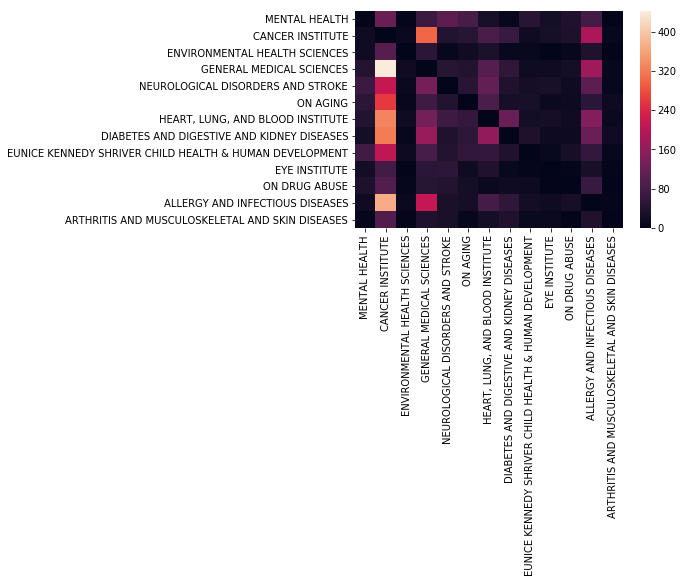

In [148]:
# create a confusion matrix
heatmap_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred), columns=labels, index=labels)

# set the diagonal (i.e. correct predictions) to zero so that they do not over-influence the heatmap legend
np.fill_diagonal(heatmap_df.values, 0)

# plot the confusion matrix
sns.heatmap(heatmap_df)

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize text
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,1))
X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)

# train model
logreg = LogisticRegression(solver='lbfgs', max_iter=300, multi_class='auto')
logreg.fit(X_train_vect, y_train)

# store predictions
y_pred = logreg.predict(X_test_vect)
y_pred_proba = logreg.predict_proba(X_test_vect)

# evaluate model
print(f'accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'log loss (cross-entropy): {metrics.log_loss(y_test, y_pred_proba)}')

accuracy: 0.6880907372400756
log loss (cross-entropy): 1.133575005796446


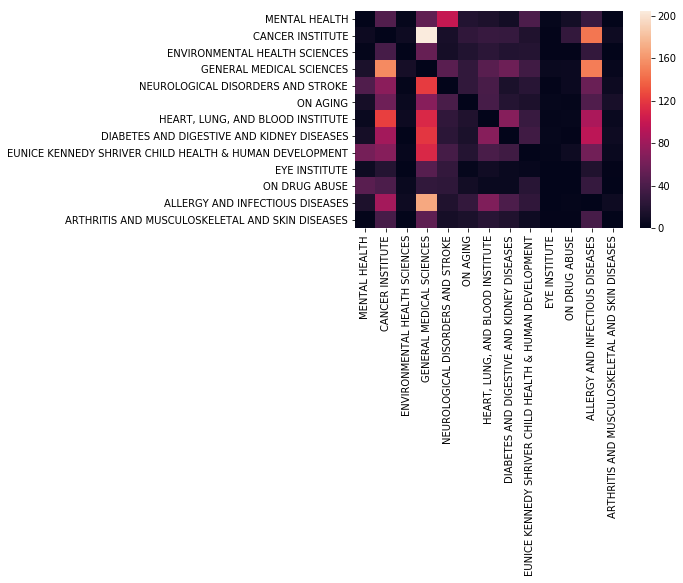

In [154]:
# create a confusion matrix
heatmap_df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred), columns=labels, index=labels)

# set the diagonal (i.e. correct predictions) to zero so that they do not over-influence the heatmap legend
np.fill_diagonal(heatmap_df.values, 0)

# plot the confusion matrix
sns.heatmap(heatmap_df)

# Full Embedding and Model Pipeline Class

In [155]:
class EmbeddingModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, 
                 max_num_words=20000, max_seq_length=50, embedding_size=50, embedding_dir=None):
                
        # set tokenizer params
        self.max_num_words = max_num_words
        self.max_seq_length = max_seq_length
        self.vocab_size = None
        self.tokenizer = None

        # format data
        self.num_classes = len(set(y_train))        
        self.y_train_array = to_categorical(y_train, self.num_classes)
        self.y_test_array = to_categorical(y_test, self.num_classes)
        self.X_train = X_train
        self.X_test = X_test
        self.X_train_sequence = self.encode_text(X_train, train=True)
        self.X_test_sequence = self.encode_text(X_test, train=False)
                
        # set embedding params
        self.embedding_dir = embedding_dir
        self.embedding_size = embedding_size
        self.embeddings_index = None
        self.embedding_matrix = None
        
        # set model params
        self.model = None
    
    def setup_model_pipeline(self):
        self.create_embeddings_index()
        self.create_embedding_matrix()
        print('model pipeline set-up complete')

    def encode_text(self, text, train=False):
        if train:
            self.tokenizer = Tokenizer(num_words=self.max_num_words)
            self.tokenizer.fit_on_texts(text)

        encoded_docs = self.tokenizer.texts_to_sequences(text)
        padded_docs = pad_sequences(
            encoded_docs,
            maxlen=self.max_seq_length,
            padding='post'
        )

        print(f'completed tokenizing and padding text - train: {train}')
        self.vocab_size = len(self.tokenizer.word_index) + 1
        return padded_docs

    def create_embeddings_index(self):
        embeddings_index = {}

        with open(self.embedding_dir, 'rb') as f:
            for line in f:
                values = line.split()
                word = values[0].decode('utf-8')
                embedding = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = embedding

        print('completed creating embedding index')
        self.embeddings_index = embeddings_index

    def create_embedding_matrix(self):
        embedding_matrix = zeros((self.vocab_size, self.embedding_size))

        for word, i in self.tokenizer.word_index.items():    
            embedding_vector = self.embeddings_index.get(word)

            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

        print('completed creating embedding matrix')
        self.embedding_matrix = embedding_matrix

    def get_embedding_layer(self):
        embedding = Embedding(
            input_dim=self.vocab_size, 
            output_dim=self.embedding_size,                                    
            input_length=self.max_seq_length,
            embeddings_initializer=Constant(self.embedding_matrix),
            trainable=False                                   
        )

        return embedding

    def fit(self, model=None, epochs=10):
        if model:
            print('using custom model')
        else:
            # default model if a custom model is not provided
            model = Sequential()
            model.add(self.get_embedding_layer())
            model.add(Flatten())
            model.add(Dense(self.num_classes, activation='softmax'))
            model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # train model
        model.fit(
            self.X_train_sequence, 
            self.y_train_array,
            epochs=epochs,
            validation_data=(self.X_test_sequence, self.y_test_array)
        )

        print('completed training model')
        self.model = model
        
    def predict(self, X):
        encoded_text = self.encode_text(X, train=False)
        y_pred = self.model.predict_classes(encoded_text)
        
        return y_pred

In [ ]:
# instantiate nlp model pipeline
embedding_model = EmbeddingModel(
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test,
    max_num_words=25000,
    max_seq_length=75,
    embedding_dir=r'glove.6B.50d.txt',
    embedding_size=50
)

# set-up and train model
embedding_model.setup_model_pipeline()
embedding_model.fit(epochs=3)

# Use context specific Embeddings

##### bioasq

"We applied word2vec to a corpus of 10,876,004 English abstracts of biomedical articles from PubMed. The resulting vectors of 1,701,632 distinct words (types) are now publicly available from http://bioasq.lip6.fr/tools/BioASQword2vec/. File size: 1.3GB (compressed), 3.5GB (uncompressed)."

SOURCE: http://bioasq.org/news/bioasq-releases-continuous-space-word-vectors-obtained-applying-word2vec-pubmed-abstracts

In [165]:
class BioasqEmbeddingModel(EmbeddingModel):

    # override the EmbeddingModel's create_embeddings_index to read in bioasq embeddings
    def create_embeddings_index(self):

        # read in a file with all the learned tokens
        with open(r'word2vecTools\types.txt', 'rb') as f:
            tokens = [line.strip().decode('utf-8') for line in f]

        # read in a file with the associated embeddings for the tokens
        with open(r'word2vecTools\vectors.txt', 'rb') as f:
            embeddings = [np.asarray(embedding.split(), dtype='float32') for embedding in f]

        # create a dict of the word --> embedding mappings
        embeddings_index = {word:embedding for word, embedding in zip(tokens, embeddings)}

        print('completed creating pubmed embedding index')
        self.embeddings_index = embeddings_index

In [ ]:
%%time

# set-up model pipeline
bioasq_model = BioasqEmbeddingModel(
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train,
    y_test=y_test,
    max_num_words=25000,
    max_seq_length=75,
    embedding_size=200
)
bioasq_model.setup_model_pipeline()

completed tokenizing and padding text - train: True
completed tokenizing and padding text - train: False


In [ ]:
%%time

# default model if a custom model is not provided
model = Sequential()
model.add(bioasq_model.get_embedding_layer())
model.add(Flatten())
model.add(Dense(bioasq_model.num_classes, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train model
bioasq_model.fit(epochs=3, model=model)

##### Biomedical natural language processing (Pubmed, PMC, and Wikipedia combined embeddings)

NOTE: This embedding file is 4GB

"The openly available biomedical literature contains over 5 billion words in publication abstracts and full texts. Recent advances in unsupervised language processing methods have made it possible to make use of such large unannotated corpora for building statistical language models and inducing high quality vector space representations, which are, in turn, of utility in many tasks such as text classification, named entity recognition and query expansion. In this study, we introduce the first set of such language resources created from analysis of the entire available biomedical literature, including a dataset of all 1- to 5-grams and their probabilities in these texts and new models of word semantics. We discuss the opportunities created by these resources and demonstrate their application. All resources introduced in this study are available under open licenses at http://bio.nlplab.org."

SOURCE: http://bio.nlplab.org/#word-vector-tools
PUBLICATION: http://bio.nlplab.org/pdf/pyysalo13literature.pdf

In [461]:
class PubmedEmbeddingModel(EmbeddingModel):

    # override the EmbeddingModel's create_embeddings_index to read in pubmed embeddings
    def create_embeddings_index(self):

        embedding_path = r'wikipedia-pubmed-and-PMC-w2v.bin'
        word_vectors = KeyedVectors.load_word2vec_format(embedding_path, binary=True)

        # create a dict of the word --> embedding mappings
        embeddings_index = {word: word_vectors.get_vector(word) for word in word_vectors.index2word}

        print('completed creating pubmed embedding index')
        self.embeddings_index = embeddings_index

In [462]:
%%time

# set-up model pipeline
pubmed_model = PubmedEmbeddingModel(
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train,
    y_test=y_test,
    max_num_words=25000,
    max_seq_length=75,
    embedding_size=200
)
pubmed_model.setup_model_pipeline()

completed tokenizing and padding text - train: True
completed tokenizing and padding text - train: False
completed creating pubmed embedding index
completed creating embedding matrix
model pipeline set-up complete
Wall time: 33.1 s


In [463]:
%%time

pubmed_model.fit(epochs=3)

Train on 46022 samples, validate on 15341 samples
Epoch 1/3
46022/46022 [==============================] - 23s 490us/step - loss: 1.6048 - acc: 0.5187 - val_loss: 1.3970 - val_acc: 0.5751
Epoch 2/3
46022/46022 [==============================] - 18s 395us/step - loss: 1.2687 - acc: 0.6187 - val_loss: 1.3263 - val_acc: 0.5934
Epoch 3/3
46022/46022 [==============================] - 18s 385us/step - loss: 1.1725 - acc: 0.6453 - val_loss: 1.3068 - val_acc: 0.5994
completed training model
Wall time: 59.7 s


# 4. build a deep learning model (e.g. convolutional neural network), ending in a softmax output.

### Convolutional Neural Networ (CNN)

In [162]:
# define model

def build_cnn_model(model):
    cnn_model = Sequential()
    cnn_model.add(model.get_embedding_layer())
    cnn_model.add(Conv1D(128, 4, activation='relu'))
    cnn_model.add(MaxPooling1D(4))
    cnn_model.add(Dropout(.1))

#    cnn_model.add(GlobalAveragePooling1D())
    cnn_model.add(Dense(units=128, activation='relu'))
    cnn_model.add(Dense(units=64, activation='relu'))

    cnn_model.add(Dense(embedding_model.num_classes, activation='softmax'))
    cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn_model

In [163]:
# set-up and train model
cnn_model = build_cnn_model(embedding_model)
embedding_model.fit(epochs=3, model=cnn_model)

using custom model
Train on 46022 samples, validate on 15341 samples
Epoch 1/3
46022/46022 [==============================] - 21s 461us/step - loss: 1.8726 - acc: 0.4022 - val_loss: 1.6513 - val_acc: 0.4862
Epoch 2/3
46022/46022 [==============================] - 20s 424us/step - loss: 1.5385 - acc: 0.5237 - val_loss: 1.4968 - val_acc: 0.5427
Epoch 3/3
46022/46022 [==============================] - 19s 408us/step - loss: 1.4097 - acc: 0.5651 - val_loss: 1.4448 - val_acc: 0.5640
completed training model


In [ ]:
cnn_model = build_cnn_model(bioasq_model)
bioasq_model.fit(epochs=15, model=cnn_model)

In [528]:
cnn_model = build_cnn_model(pubmed_model)
pubmed_model.fit(epochs=6, model=cnn_model)

Train on 46022 samples, validate on 15341 samples
Epoch 1/6
46022/46022 [==============================] - 29s 639us/step - loss: 1.6046 - acc: 0.5183 - val_loss: 1.3965 - val_acc: 0.5799
Epoch 2/6
46022/46022 [==============================] - 21s 456us/step - loss: 1.2689 - acc: 0.6165 - val_loss: 1.3215 - val_acc: 0.5954
Epoch 3/6
46022/46022 [==============================] - 20s 445us/step - loss: 1.1727 - acc: 0.6438 - val_loss: 1.3039 - val_acc: 0.6005ss: 1.1719 - acc
Epoch 4/6
46022/46022 [==============================] - 22s 476us/step - loss: 1.1168 - acc: 0.6594 - val_loss: 1.2962 - val_acc: 0.6004
Epoch 5/6
46022/46022 [==============================] - 22s 475us/step - loss: 1.0775 - acc: 0.6692 - val_loss: 1.2957 - val_acc: 0.6047
Epoch 6/6
46022/46022 [==============================] - 21s 456us/step - loss: 1.0485 - acc: 0.6790 - val_loss: 1.3003 - val_acc: 0.6040 11s -  - ETA: 10s - loss: 1.0379 - - ETA: 9s - loss: 1.0364 - acc: 0.68 - ETA: 9s - loss: 1 - ETA: 8s - - 

### LSTM

In [535]:
# define model
def build_lstm(model):
    lstm_model = Sequential()
    lstm_model.add(model.get_embedding_layer())
    lstm_model.add(LSTM(64))
    lstm_model.add(Dense(embedding_model.num_classes, activation='softmax'))
    lstm_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return lstm_model

In [451]:
# set-up and train model
lstm_model = build_lstm(embedding_model)
embedding_model.fit(epochs=4, model=lstm_model)

using custom model
Train on 46022 samples, validate on 15341 samples
Epoch 1/4
46022/46022 [==============================] - 102s 2ms/step - loss: 2.1675 - acc: 0.2558 - val_loss: 2.0268 - val_acc: 0.3135s - loss: 2.1727 - acc: 0.253 - ETA: 2s  - ETA: 0s - loss: 2.1693 - 
Epoch 2/4
46022/46022 [==============================] - 101s 2ms/step - loss: 1.8809 - acc: 0.3876 - val_loss: 1.8669 - val_acc: 0.3991
Epoch 3/4
46022/46022 [==============================] - 100s 2ms/step - loss: 1.7459 - acc: 0.4539 - val_loss: 1.7700 - val_acc: 0.4317c: 0.453 - ETA: 0s - loss: 1.7469 - acc
Epoch 4/4
46022/46022 [==============================] - 97s 2ms/step - loss: 1.6422 - acc: 0.4933 - val_loss: 1.6349 - val_acc: 0.4956- loss: 1.6437 -  - ETA: 5s - loss: 1.6429 - ETA: 5s - loss: 1. - ETA: 3s - l -
completed training model


In [536]:
# set-up and train model
lstm_model = build_lstm(bioasq_model)
bioasq_model.fit(epochs=10, model=lstm_model)

using custom model
Train on 46022 samples, validate on 15341 samples
Epoch 1/10
46022/46022 [==============================] - 173s 4ms/step - loss: 1.5336 - acc: 0.5225 - val_loss: 1.3067 - val_acc: 0.6036
Epoch 2/10
46022/46022 [==============================] - 180s 4ms/step - loss: 1.1605 - acc: 0.6502 - val_loss: 1.1643 - val_acc: 0.6462
Epoch 3/10
46022/46022 [==============================] - 183s 4ms/step - loss: 1.0580 - acc: 0.6780 - val_loss: 1.0945 - val_acc: 0.6674
Epoch 4/10
46022/46022 [==============================] - 167s 4ms/step - loss: 0.9971 - acc: 0.6937 - val_loss: 1.0614 - val_acc: 0.6794
Epoch 5/10
46022/46022 [==============================] - 163s 4ms/step - loss: 0.9509 - acc: 0.7066 - val_loss: 1.0871 - val_acc: 0.6720
Epoch 6/10
46022/46022 [==============================] - 165s 4ms/step - loss: 0.9127 - acc: 0.7162 - val_loss: 1.0245 - val_acc: 0.6874
Epoch 7/10
46022/46022 [==============================] - 184s 4ms/step - loss: 0.8792 - acc: 0.7274 - 

In [ ]:
lstm_model = build_lstm(pubmed_model)
pubmed_model.fit(epochs=11, model=lstm_model)

using custom model
Train on 46022 samples, validate on 15341 samples
Epoch 1/11
46022/46022 [==============================] - 332s 7ms/step - loss: 1.9865 - acc: 0.3154 - val_loss: 1.7865 - val_acc: 0.4128
Epoch 2/11
46022/46022 [==============================] - 326s 7ms/step - loss: 1.6511 - acc: 0.4730 - val_loss: 1.5636 - val_acc: 0.5154: 
Epoch 3/11
46022/46022 [==============================] - 342s 7ms/step - loss: 1.4599 - acc: 0.5602 - val_loss: 1.4671 - val_acc: 0.5521
Epoch 4/11
46022/46022 [==============================] - 319s 7ms/step - loss: 1.3444 - acc: 0.6062 - val_loss: 1.3386 - val_acc: 0.6104
Epoch 5/11
46016/46022 [============================>.] - ETA: 0s - loss: 1.2632 - acc: 0.6325

# FLAIR 

In [ ]:
https://github.com/zalandoresearch/flair/blob/master/flair/embeddings.py
    
embedding example: 
#    def _add_embeddings_internal(self, sentences: List[Sentence]) -> List[Sentence]: